### FrozenLake - Value Iteration Method

In [21]:
import gym 
import collections
import time

import numpy as np
import pandas as pd
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns

from tensorboardX import SummaryWriter
from IPython.display import clear_output

pd.set_option('display.max.columns', 500)
plt.rcParams['figure.figsize'] = [3, 3]

### The Game:

<img src='Images/frozen_lake.gif' width='250' style='float:left; margin:0px 50px 0px 0px'/>

- The world is from the so-called grid world category:
- Agent lives in a grid of size 4×4, can move in four directions: up, down, left, and right
- Agent always starts at a top-left position, and its goal is to reach the bottom-right
- There are holes in the fixed cells of the grid that if hit, episode ends and your reward is zero. 
- If agent reaches the destination cell, reward of 1.0 and the episode ends
- The world is slippery, so the agent's actions do not always turn out as expected¨
- There is a 33% chance that it will slip to the right or to the left. 
- If you want the agent to move left, for example, there is a 33% probability that it will, indeed, move left, a 33% chance that it will end up in the cell above, and a 33% chance that it will end up in the cell below. 
- As you will see at the end of the section, this makes progress difficult.

In [22]:
env = gym.make('FrozenLake-v1', render_mode='rgb_array')

In [23]:
env.observation_space

Discrete(16)

Observation space is the discrete range from 0 to 15, i.e. the position in the grid. This will have to be one-hot encoded for the neural network from the Cartpole example.

In [24]:
env.action_space

Discrete(4)

Action space is discrete range from 0 to 3, i.e. up, right, down or left.

In [25]:
env.reset()

(0, {'prob': 1})

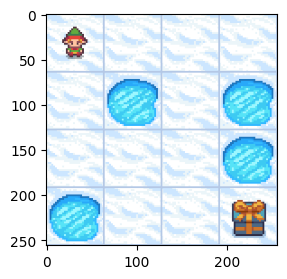

In [26]:
plt.imshow(env.render())

Looks like this when fallen in:

<img src="Images/fallen_in.png" width=300>

### How does a `defaultdict` work?

`defaultdict` doesn't throw KeyError if element is not found. Instead, a new entry is created. The type of this new entry is given by the argument of defaultdict:`

In [27]:
somedict = collections.defaultdict(float)
somedict[0] = 'example'
somedict[1] = 'dict'
print(somedict[1])
print(somedict[2])

dict
0.0


In [28]:
somedict = collections.defaultdict(collections.Counter)
somedict[0] = 'example'
somedict[1] = 'dict'
print(somedict[1])
print(somedict[2])

dict
Counter()


As shown above, it just returns the default value for an unknown key.

### How does a `Counter()` Object work?

The Counter object is essentially a specialized dictionary that counts the occurrences of its elements. When you add elements to a Counter, it keeps track of the counts for each element. Here's an example:

In [29]:
c = collections.Counter()
c['cat'] += 1
c['dog'] += 1
c['cat'] += 1
c

Counter({'cat': 2, 'dog': 1})

In [30]:
c.items()

dict_items([('cat', 2), ('dog', 1)])

In [31]:
sum(c.values()) # calculate total occurences

3

And in the Agent class, we have a counter in a `defaultdict` for any imaginable key combination of state and action there is. If we then use the second edge brackets with the state that we transitioned to, it will count the occurence +1 in the Counter's dictionary.

In [32]:
transits = collections.defaultdict(collections.Counter)
transits[(0, 0)][1]

0

In [33]:
transits[(0, 0)][1] += 1
transits[(0, 0)][1]

1

In [34]:
transits[(0, 0)][1] += 1
transits[(0, 0)][1]

2

This says: From state 0, using action 0, we landed in state 1. This happened to times, so we increment the counter two times.

### Defining the Agent 🤖

The agent is now not a Neural Network anymore, but a class that takes note of the
- rewards that were obtained,
- transitions to new states that were made and
- values of any given state (which is the expected value of the immediate reward and the discounted value of the next state, see Bellman update).

In [35]:
# ENV_NAME = 'FrozenLake-v1'
GAMMA = 0.9
TEST_EPISODES = 30

In [36]:
class Agent:
    def __init__(self, env):
        # Initialise environment and get initial state
        self.env = env
        self.state, _ = self.env.reset()
        # Initialise the tables for rewards, transition probs and state values
        self.rewards = collections.defaultdict(float)
        self.transits = collections.defaultdict(collections.Counter)
        self.values = collections.defaultdict(float)

    def play_n_random_steps(self, count):
        '''
        Function takes random steps (N) to explore the environment and
        gather experience to be able to learn from. Episodes do not
        need to end, they can be terminated early, as opposed to CE Method
        '''
        for _ in range(count):
            # Take a random action sampled from action space
            action = self.env.action_space.sample()
            # Take a step and get new information
            new_state, reward, is_done, is_truncated, _ = self.env.step(action)
            # Reward table gets filled for each state, action and new state pair
            self.rewards[(self.state, action, new_state)] = reward
            # Increase counter of the state and action pair
            self.transits[(self.state, action)][new_state] += 1
            # Either reset if Episode ended or continue next step
            if is_done or is_truncated:
                self.state, _ = self.env.reset()
            else:
                self.state = new_state

    def calc_action_value(self, state, action):
        '''
        Calculate the action values for two reasons
            1) to select best action from a given state
            2) to calculate the new value of the state on value iteration
        '''
        # Get counter object for each state and action
        # that shows the counts for destination states
        target_counts = self.transits[(state, action)]
        # Calculate the total number of state/action pair
        total = sum(target_counts.values())
        # Initialise value of this particular action at zero
        action_value = 0.0
        # for each target state and count in the Counter() dict
        for tgt_state, count in target_counts.items():
            # get the reward from the reward table
            reward = self.rewards[(state, action, tgt_state)]
            # Update the action value as such:
            # Expected value of the action plus discounted value of 
            # the target state: Bellman Update V0 = E[r + gamma * V1]
            action_value += (count / total) * (reward + GAMMA * self.values[tgt_state])
            # For loop increments the action value to an expected value
        return action_value
    
    def select_action(self, state):
        '''
        Function is given a state and calls the value calculation
        for an action given a state. It then returns the best action
        given the state.
        '''
        best_action, best_value = None, None
        # for each action in the entire action space
        for action in range(self.env.action_space.n):
            # calculate the value of each action given the state
            action_value = self.calc_action_value(state, action)
            # If best value is below the current action value
            if best_value is None or best_value < action_value:
                # then update the best value
                best_value = action_value
                # and make this action the new best action given the state
                best_action = action
        return best_action
        
    def play_episode(self, env):
        '''
        This function plays exactly one episode and returns the total
        reward of the episode. It also continues to store experience from
        exploration in the defaultdicts and updates the action values.
        '''
        # initialise reward of episode as nothing
        total_reward = 0.0
        # get initial observation
        state, _ = env.reset()
        while True:
            # Select the best action (function calls another function
            # that calculates the value for each action given the state)
            action = self.select_action(state)
            # Take the action
            new_state, reward, is_done, is_truncated, _ = env.step(action)
            # Continue gathering experience, store rewards
            self.rewards[(state, action, new_state)] = reward
            # Store transitions
            self.transits[(state, action)][new_state] += 1
            # update the reward gained from the step taken
            total_reward += reward
            # if Episode is over, break the while loop
            if is_done or is_truncated:
                break
            # If not broken, then new state is the one gained from
            # the action that was taken
            state = new_state 
        # return the total reward of the episode every step?
        return total_reward
    
    def value_iteration(self):
        '''
        Performs value iteration to update the state values of each state in the environment.
        The optimal state value function is the maximum expected cumulative reward that can 
        be obtained from each state by following the optimal policy. This method updates the
        state values by iterating over each state, and for each state it calculates the action
        value for each possible action, and updates the state value to the maximum action value.
        This method does not return anything, but updates the `values` attribute of the agent 
        object.
        '''
        # for every state in the observation space
        for state in range(self.env.observation_space.n):
            # for each state and action pair, calculate an action value
            state_values = [self.calc_action_value(state, action) 
                            for action in range(self.env.action_space.n)]
            # update the value of the state as the maximum value for each
            # of the actions that can be taken
            self.values[state] = max(state_values)

    def demonstrate_episodes(self, env, episodes):
        for episode in range(episodes):
            episode_reward = 0.0
            state, _ = env.reset()
            
            while True:
                action = self.select_action(state)
                # take a step
                next_state, reward, is_done, is_truncated, _ = env.step(action)
                episode_reward += reward
                state = next_state
                
                clear_output(wait=True)
                plt.imshow(env.render())
                plt.show()

                if is_done or is_truncated:
                    break

            print(f"Episode {episode + 1}: {episode_reward} reward")
            if episode_reward == 1:
                print("SUCCESS")
            else:
                print("FAIL")

            time.sleep(1)

### How the Agent Class works in detail:

_**__init__(self)**_:
***

This method initialises the object's attributes, which are
- the environment
- the initial state
- the tables for
    - rewards
    - transitions (frequencies, i.e. counts)
    - values of the states

_**play_n_random_steps(self, count)**_:
***

This method let's the agent play $N$ random steps. Random means: No policy other than sampling any of the available actions at random for each step. While doing so, at each step
- new state, reward for last step and is_done flags are noted
- the reward table is updated with the immediate reward given $\text{(state, action, new state)}$ pair
- the Counter object in the transit table is updated given the $\text{(state, action, new state)}$ pair

This is necessary for the agent to gather first experience before starting to learn, in order to explore the environment.

_**calc_action_value(self, state, action)**_:
***

This method calculates the action value for a given state and action for two reasons:

1. To select the best action from a given state
2. To calculate the new value of a state on value iteration (as you need the values of each action to calculate the value of a state, expected value)

It gets the counter object for each state and action and initialises the actions value as 0. Then, for each of the transition states and counts (pair, not combination), it gets the latest reward received in this $\text{(state, action, new state)}$ combination from the rewards table, then adds the weighted instant reward plus discounted value of the transition state to the action value (Bellman Update). With all transition states in the Counter, this will form the expected value of the action given the state.

_**select_action(self, state)**_:
***

This method takes in a state and then returns the best action given the state. It does so by (for each action in the action space)
- calculating the action value (given the current state)
- comparing if this action value is higher than all other action values given the state

_**play_episode(self, env)**_:
***

This method plays one episode and returns the total reward of it. It
- initialises the reward of the episode at 0,
- gets the initial observation
- does steps through the environment and ends if the episode is done or truncated
- all the while continuing to update the reward and transits table

_**value_iteration(self)**_:
***

This method does not return anything. Instead, for each state in the state space (observation space), it
- loops through all possible actions given that state and stores them in a list
- stores the maximum action value for this state in the state values table as the state's value

This means, that the value of a state is nothing but the maximum value that you can expect given a certain action from it (which is composed of immediate reward and the discounted value of the next state).

_**demonstrate_episodes(self, env, episodes)**_:
***

This method was written by me and visualises the trained agent playing the game.

In [37]:
# Training the agent:
test_env = gym.make('FrozenLake-v1')
agent = Agent(env=test_env)

iter_no = 0
best_reward = 0.0
while True:
    iter_no += 1
    # Play 100 random steps to get experience
    agent.play_n_random_steps(100)
    # Calculate the state values
    agent.value_iteration()

    reward = 0.0
    # Run N Test Episodes and add up the rewards
    for _ in range(TEST_EPISODES):
        reward += agent.play_episode(test_env)
    # Calculate average reward over the test episodes
    reward /= TEST_EPISODES

    # Update if the new average reward is better than all previous
    if reward > best_reward:
        print(f"Iteration {iter_no}: Best reward updated {best_reward:.2f} -> {reward:.2f}")
        best_reward = reward
    if reward >= 0.85:
        print(f"Solved in {iter_no} iterations!")
        break

Iteration 6: Best reward updated 0.00 -> 0.03
Iteration 9: Best reward updated 0.03 -> 0.20
Iteration 10: Best reward updated 0.20 -> 0.30
Iteration 11: Best reward updated 0.30 -> 0.43
Iteration 12: Best reward updated 0.43 -> 0.53
Iteration 13: Best reward updated 0.53 -> 0.63
Iteration 15: Best reward updated 0.63 -> 0.67
Iteration 16: Best reward updated 0.67 -> 0.73
Iteration 34: Best reward updated 0.73 -> 0.83
Iteration 83: Best reward updated 0.83 -> 0.90
Solved in 83 iterations!


In [38]:
state_values = (pd.DataFrame(agent.values.items(),
                             columns=['State', 'Value'])
                .assign(row=lambda x: x.State // 4,
                        col=lambda x: x.State % 4)
                )

state_values.head()

,State,Value,row,col
0,0,0.064940,0,0
1,4,0.087570,1,0
2,1,0.056741,0,1
3,2,0.072144,0,2
4,5,0.000000,1,1


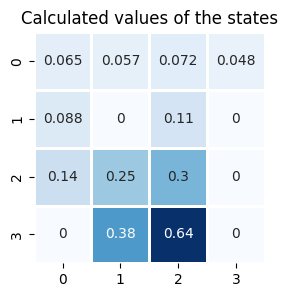

In [39]:
# pivot the data to create a matrix
mat = state_values.pivot(index='row', columns='col', values='Value')

# create the plot using seaborn heatmap
ax = sns.heatmap(mat, cmap='Blues', annot=True, square=True,
                 linewidths=1, cbar=False)
ax.set_title("Calculated values of the states")

# set axis labels
plt.xlabel(None)
plt.ylabel(None)

# show the plot
plt.show()

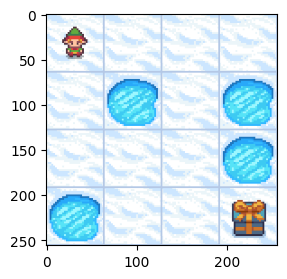

In [41]:
plt.imshow(env.render())

### Letting the trained agent play

Problem shows: Exploration vs. exploitation dilemma! If you always exploit, you get stuck in local optima and might go left against the edge forever.

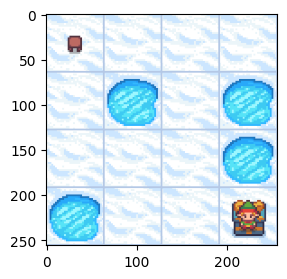

Episode 2: 1.0 reward
SUCCESS


In [42]:
agent.demonstrate_episodes(env, 2)

### Training the Agent in a custom terrain

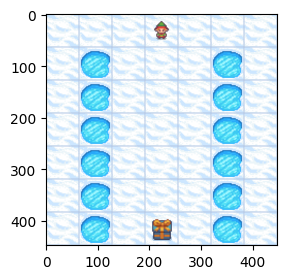

In [43]:
test_env = gym.make('FrozenLake-v1', desc=["FFFSFFF",
                                           "FHFFFHF",
                                           "FHFFFHF",
                                           "FHFFFHF",
                                           "FHFFFHF",
                                           "FHFFFHF",
                                           "FHFGFHF"],
                    render_mode='rgb_array', is_slippery=True)
agent = Agent(env=test_env)

env.reset()
plt.imshow(test_env.render())

In [44]:
iter_no = 0
best_reward = 0.0

while True:
    iter_no += 1
    # Play 100 random steps to get experience
    agent.play_n_random_steps(200)
    # Calculate the state values
    agent.value_iteration()

    reward = 0.0
    # Run N Test Episodes and add up the rewards
    for _ in range(TEST_EPISODES):
        reward += agent.play_episode(test_env)
    # Calculate average reward over the test episodes
    reward /= TEST_EPISODES

    # Update if the new average reward is better than all previous
    if reward > best_reward:
        print(f"Iteration {iter_no}: Best reward updated {best_reward:.2f} -> {reward:.2f}")
        best_reward = reward
    if reward >= 1:
        print(f"Solved in {iter_no} iterations!")
        break

Iteration 4: Best reward updated 0.00 -> 0.03
Iteration 5: Best reward updated 0.03 -> 0.07
Iteration 6: Best reward updated 0.07 -> 0.17
Iteration 9: Best reward updated 0.17 -> 0.30
Iteration 11: Best reward updated 0.30 -> 0.40
Iteration 12: Best reward updated 0.40 -> 0.47
Iteration 14: Best reward updated 0.47 -> 0.50
Iteration 16: Best reward updated 0.50 -> 0.60
Iteration 17: Best reward updated 0.60 -> 0.70
Iteration 22: Best reward updated 0.70 -> 0.77
Iteration 26: Best reward updated 0.77 -> 0.87
Iteration 30: Best reward updated 0.87 -> 0.90
Iteration 38: Best reward updated 0.90 -> 0.97
Iteration 276: Best reward updated 0.97 -> 1.00
Solved in 276 iterations!


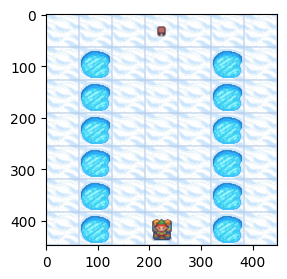

Episode 2: 1.0 reward
SUCCESS


In [46]:
agent.demonstrate_episodes(test_env, 2)

### 8x8 Non-Slippery Method: Stuck in sub-optimal policy

Why does the Agent get stuck in this left corner?
After 1.5h of training, agent just walks in circles


The FrozenLake environment is a grid world with slippery and non-slippery frozen tiles and a hole. In the non-slippery version, the agent always moves in the direction it intends to move. However, the agent may still get stuck walking in circles due to the way the value iteration algorithm is implemented. In particular, the agent may get stuck in a loop where it repeatedly visits the same set of states, which can happen when the agent has not learned a good policy for escaping from those states. The agent continues to update its value estimates based on the same set of states, resulting in a feedback loop that reinforces the behavior of staying in the same set of states. One way to address this issue is to introduce additional randomness in the agent's actions, such as with an epsilon-greedy policy, which encourages exploration of new states.

### Training the Agent in Non-Slippery Terrain

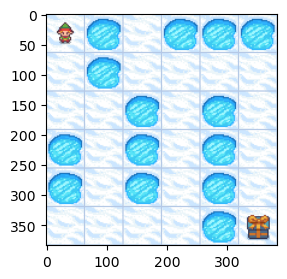

In [35]:
test_env = gym.make('FrozenLake-v1', desc=["SHFHHH",
                                           "FHFFFF",
                                           "FFHFHF",
                                           "HFHFHF",
                                           "HFHFHF",
                                           "FFFFHG"],
                    render_mode='rgb_array', is_slippery=False)

test_env.reset()
plt.imshow(test_env.render())

This will take ages to explore. Can I change the reward structure?

Difficult, as it will lead to other problems and undesirable behaviour. How can this problem be rectified?

In [36]:
# Define a new environment wrapper
class ModifiedFrozenLake(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        
    def step(self, action):
        new_state, reward, done, truncated, info = self.env.step(action)
        if done and reward == 0.0:  # fell into a hole
            reward = -1
        elif reward == 0.0:  # stepped on ice
            reward = 0
        elif done and reward == 1.0:  # reached the goal
            reward = 1
        return new_state, reward, done, truncated, info

test_env = ModifiedFrozenLake(test_env)

In [40]:
agent = Agent(env=test_env)

iter_no = 0
best_reward = 0.0

while True:
    iter_no += 1
    # Play random steps to get experience
    agent.play_n_random_steps(100000)
    # Calculate the state values
    agent.value_iteration()

    reward = 0.0
    # Run N Test Episodes and add up the rewards
    for _ in range(TEST_EPISODES):
        reward += agent.play_episode(test_env)
    # Calculate average reward over the test episodes
    reward /= TEST_EPISODES

    agent.value_iteration()

    # Update if the new average reward is better than all previous
    if reward > best_reward:
        print(f"Iteration {iter_no}: Best reward updated {best_reward:.2f} -> {reward:.2f}")
        best_reward = reward
    if reward >= 1:
        print(f"Solved in {iter_no} iterations!")
        break

Iteration 3: Best reward updated 0.00 -> 1.00
Solved in 3 iterations!


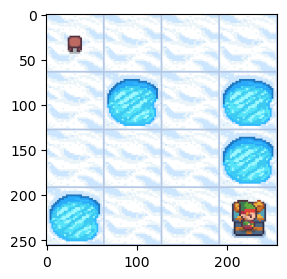

Episode 1: 1.0 reward
SUCCESS


In [44]:
agent.demonstrate_episodes(test_env, 1)

### Exploration takes too long

4x4 geht, 6x6 ist zu gross zum exploren